# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Titanic - Machine Learning from Disaster (ML)</p>

<blockquote style="margin-right:auto; margin-left:auto; background-color:#26344e; padding: 15px; border-radius: 10px 10px">
    <b><span style="color:#f2f2f0; font-size:20px; font-family:JetBrains Mono; margin-left: 10px;">
        Competition Description 📜
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Task 🕵
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        See More Here 📈
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        <a href="https://www.kaggle.com/competitions/titanic/overview">Titanic - Machine Learning from Disaster</a>
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        This Notebook Covers 📔
    </span></b>
    <ul style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 10px; margin-right: 15px; margin-top: 15px; margin-bottom: 20px">
        <li>Building own custom transformer and preprocessing pipeline.</li>
        <li>Getting through the feature importance problem.</li>
        <li>Comparison of different models' baseline scores.</li>
        <li>Metrics visualisations with Plotly.</li>
        <li>Choosing the best model and tuning it.</li>
        <li>Final submission.</li>
    </ul>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Exploratory Data Analysis Notebook 📊
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        In this notebook, I handle machine learning and feature importance in general. If you're interested in EDA, please see the link below.<br>
        <a href="https://www.kaggle.com/code/mateuszk013/titanic-visual-eda-with-insights">Titanic - Visual EDA with Insights</a>
    </p>
</blockquote>

In [130]:
# %load ../initial_settings.py
import os
import shutil
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colorama import Fore, Style
from IPython.display import display_html
from matplotlib.patches import PathPatch

# =============================================================================
# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Here we store models if these are interesting.
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Matplotlib & Seaborn settings.
FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#2a357d", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

# =============================================================================
# Utility functions.
def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


# =============================================================================
def adjust_box_widths(g, factor, orient="v"):
    """
    Adjust the widths/heights of a seaborn-generated boxplot.
    """
    if orient not in ("v", "h"):
        raise ValueError("The `orient` should be 'v' or 'h'.")

    i = 1
    if orient == "h":
        i = 0

    # iterating through Axes instances
    for ax in g.axes:
        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current height/width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                min_ = np.min(verts_sub[:, i])
                max_ = np.max(verts_sub[:, i])
                mid_ = 0.5 * (min_ + max_)
                half_ = 0.5 * (max_ - min_)

                # setting new height/width of box
                min_new_ = mid_ - factor * half_
                max_new_ = mid_ + factor * half_
                verts_sub[verts_sub[:, i] == min_, i] = min_new_
                verts_sub[verts_sub[:, i] == max_, i] = max_new_

                # setting new height/width of median line
                if orient == "v":
                    for l in ax.lines:
                        if len(l.get_ydata()) == 2 and np.all(
                            l.get_ydata() == [min_, max_]
                        ):
                            l.set_ydata([min_new_, max_new_])
                elif orient == "h":
                    for l in ax.lines:
                        if len(l.get_xdata()) == 2 and np.all(
                            l.get_xdata() == [min_, max_]
                        ):
                            l.set_xdata([min_new_, max_new_])


# =============================================================================
# This patch comes from.
# https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Parameter, Signature, signature

    import pandas as pd
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        # print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(KNNImputer, "get_feature_names_out"):
        # print("Monkey-patching KNNImputer.get_feature_names_out()")
        KNNImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        # print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


if ON_KAGGLE:
    monkey_patch_get_signature_names_out()


# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Custom Transformers & Preprocessing Pipelines</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>We continue work on the Titanic dataset and put into practice things we know from the EDA notebook: <a href="https://www.kaggle.com/code/mateuszk013/titanic-visual-eda-with-insights">Titanic - Visual EDA with Insights</a>.</li>
    <li>In this notebook, I use only <code>scikit-learn</code> tools.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>In this section, we'll write a simple custom transformer compatible with <code>scikit-learn</code> pipelines. Our transformer simply adds three new features to the data frame. These are <code>IsAlone</code>, <code>Title</code> and <code>CabinDeck</code></li>
</ul>

In [131]:
competition = "titanic"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="PassengerId")
test = pd.read_csv(test_path, index_col="PassengerId")


In [132]:
train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [133]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class NewFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self  # Always returns self.

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")
        check_is_fitted(self)

        Xc = X.copy()
        Xc["IsAlone"] = Xc.eval("SibSp + Parch == 0").astype(int)

        Xc["Title"] = Xc["Name"].str.extract(r" ([A-Za-z]+)\.")
        common_titles = ["Mr", "Miss", "Mrs", "Master"]
        unique_titles = np.setdiff1d(Xc["Title"], common_titles).tolist()
        Xc["Title"] = Xc["Title"].replace(unique_titles, "Other")

        Xc["CabinDeck"] = Xc["Cabin"].str[0]

        return Xc

    def get_feature_names_out(self, input_features=None):
        return np.r_[self.feature_names_in_, ["IsAlone", "Title", "CabinDeck"]]


In [134]:
nfa = NewFeatureAdder()
train_new = nfa.fit_transform(train)
train_new.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAlone,Title,CabinDeck
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Mrs,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,NaN


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As you can see, everything works as it should. This method may seem useless for you since we can simply add these features to the data frame without any external class. However, such an operation is compatible with <code>scikit-learn</code>, so you can include this class in auto-preprocessing pipelines.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Now we'll handle the auto-preprocessing pipeline that prepares data for machine learning algorithms.</li>
</ul>

In [135]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import set_config


preprocess = make_pipeline(
    NewFeatureAdder(),
    make_column_transformer(
        (
            StandardScaler(),
            ["Age"],
        ),
        (
            make_pipeline(
                SimpleImputer(strategy="median"),
                FunctionTransformer(
                    func=np.log1p, inverse_func=np.expm1, feature_names_out="one-to-one"
                ),
                StandardScaler(),
            ),
            ["Fare"],
        ),
        (
            make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(handle_unknown="ignore"),
            ),
            ["Pclass", "Sex", "Embarked", "IsAlone", "Title"],
        ),
        verbose_feature_names_out=False,
    ),
    # At this stage, only the `Age` attribute needs imputation.
    KNNImputer(n_neighbors=5),
)

set_config(display="diagram")
preprocess

Pipeline(steps=[('newfeatureadder', NewFeatureAdder()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Age']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'IsAlone', 'Title'])],
                                   verbose_feature_names_out=False)),
                ('knnimputer', KNNImputer())])

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>The <code>preprocess</code> pipeline takes the data frame and adds new features within <code>NewFeatureAdded</code>. Then we use <code>make_column_transformer</code>, which "splits" this data frame into three parts. The first part contains <code>Age</code>, which is normalised with <code>StandardScaler</code>, and the second part contains <code>Fare</code>, where we first impute missing values with median, then use log-level transformation on these samples and finally scale them with <code>StandardScaler</code>. The third part is composed of <code>Pclass</code>, <code>Sex</code>, <code>Embarked</code>, <code>IsAlone</code>, and <code>Title</code>. We impute missing values with the most frequent ones and then use one hot encoding. The <code>verbose_feature_names_out</code> parameter provides that feature names don't have prefixes from used pipelines. The last step concerns imputing missing values in the <code>Age</code> attribute. Since we use k-Nearest Neighbors, all features should be scaled so that features with higher values do not predominate in distance metrics.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see whether it works and how it looks.</li>
</ul>

In [165]:
y = train["Survived"]
X = train.drop("Survived", axis=1)

X_full = preprocess.fit_transform(X)
y_full = y

assert np.all(np.isfinite(X_full)) == True
assert np.any(np.isnan(X_full)) == False

feature_names_out = preprocess.get_feature_names_out()
pd.DataFrame(X_full, columns=feature_names_out).head()


,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAlone_0,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,-0.530377,-0.879741,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.571831,1.361220,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.254825,-0.798540,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.365167,1.062038,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.365167,-0.784179,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>It seems to work fine.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Since we have prepared data we can go to feature importance measurements with <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Feature Importance</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>In this section, we will handle feature importance within different methods.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Firstly let's see a simple decision tree and its splits criteria.</li>
</ul>

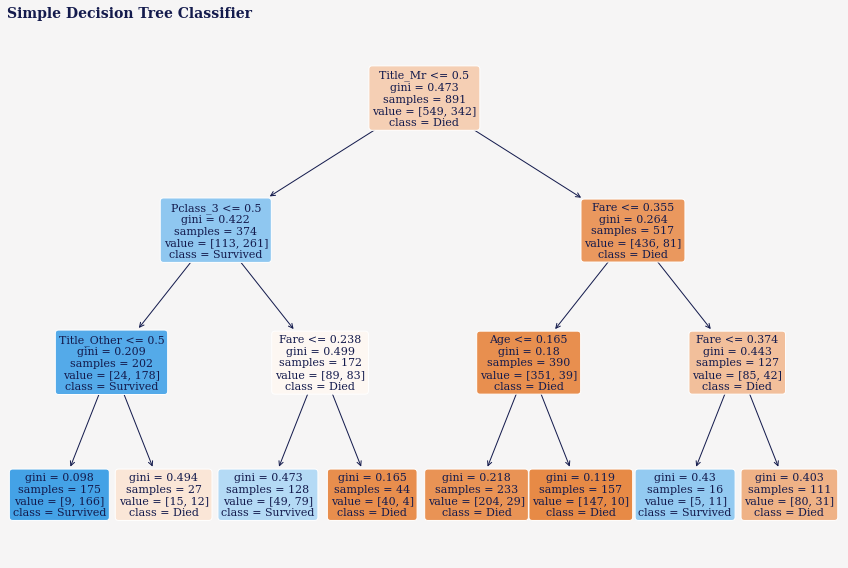

In [137]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_full, y_full)
y_classes = pd.Series(tree_clf.classes_).map({0: "Died", 1: "Survived"})

fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
plot_tree(
    decision_tree=tree_clf,
    feature_names=feature_names_out,
    class_names=y_classes,
    filled=True,
    rounded=True,
    ax=ax,
    fontsize=11,
)
plt.title("Simple Decision Tree Classifier", loc="left")
plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Decision trees are beneficial due to the possibility of their visualisation. Here we see that splitting criteria are based on <code>Title</code>, <code>Pclass</code> and <code>Age</code>.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see feature importance within <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
</ul>

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif


lda = LinearDiscriminantAnalysis()
lda.fit(X_full, y_full)
lda_info = np.abs(lda.scalings_.ravel())
lda_info = lda_info / lda_info.sum()

forest = RandomForestClassifier(random_state=42)
forest.fit(X_full, y_full)
forest_info = forest.feature_importances_

mutual_info = mutual_info_classif(X_full, y_full, random_state=42)
mutual_info = mutual_info / np.sum(mutual_info)

importances = pd.DataFrame(
    [lda_info, forest_info, mutual_info],
    columns=feature_names_out,
    index=["LDA", "Random Forest", "Mutual Information"],
).T

importances = importances.loc[
    importances.mean(axis=1).sort_values(ascending=False).index
]

importances.style.background_gradient(DF_CMAP)


,LDA,Random Forest,Mutual Information
Sex_male,0.161807,0.100044,0.164644
Fare,0.000720,0.254027,0.135363
Sex_female,0.161807,0.083256,0.137042
Age,0.026041,0.254606,0.050010
Title_Master,0.228473,0.013250,0.042140
Title_Mr,0.003820,0.086830,0.143604
Pclass_3,0.089353,0.055010,0.047812
Pclass_1,0.104231,0.028304,0.027425
Title_Miss,0.067486,0.022847,0.066476
Title_Mrs,0.001493,0.023908,0.064630


In [139]:
melted = (
    importances.melt(var_name="Method", value_name="Importance", ignore_index=False)
    .reset_index()
    .rename(columns={"index": "Feature"})[::-1]
)

fig = px.bar(
    data_frame=melted,
    x="Importance",
    y="Feature",
    color="Method",
    barmode="group",
    height=700,
    width=800,
    color_discrete_sequence=px.colors.diverging.delta,
    title="Normalised Feature Importances",
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Feature importances from all methods are normalised to one, so we can easily compare them.</li>
    <li>Since the dataset is normalised, the feature importance measure with <code>LDA</code> is based on discriminator weights. This approach constitutes a computationally efficient feature selection method.</li>
    <li>Feature importance measure with <code>RandomForestClassifier</code> is based on Gini impurity decrease. It measures how including a specific feature contributes to the homogeneity of the node.</li>
    <li><code>Mutual Information</code> measures the dependency between variables. It equals zero if two random variables are independent, and higher values mean higher dependency.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's stay with the feature importance problem and see how the accuracy of <code>RandomForestClassifier</code> changes when we randomly permute samples in a specific attribute. Random permutation of variable results in removing all predictive power for this attribute.</li>
</ul>

In [162]:
from collections import defaultdict

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
forest = RandomForestClassifier(random_state=42)
acc_scores = defaultdict(list)
np.random.seed(42)

for k, (train_ids, valid_ids) in enumerate(skfold.split(X, y)):

    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    X_train = preprocess.fit_transform(X_train)
    X_valid = preprocess.transform(X_valid)

    forest.fit(X_train, y_train)
    acc = accuracy_score(y_valid, forest.predict(X_valid))

    for i, feature in enumerate(feature_names_out):
        X_shuffled = X_valid.copy()
        X_shuffled[:, i] = np.random.permutation(X_shuffled[:, i])
        acc_shuffled = accuracy_score(y_valid, forest.predict(X_shuffled))
        acc_scores[feature].append((acc - acc_shuffled) / acc)

    print(CLR + "Fold: ", f"{BLUE}{k}", f"\t{CLR}Baseline Accuracy: {BLUE}{acc:.3f}")


Fold:  0 	Baseline Accuracy: 0.822
Fold:  1 	Baseline Accuracy: 0.798
Fold:  2 	Baseline Accuracy: 0.798
Fold:  3 	Baseline Accuracy: 0.820
Fold:  4 	Baseline Accuracy: 0.820
Fold:  5 	Baseline Accuracy: 0.798
Fold:  6 	Baseline Accuracy: 0.854
Fold:  7 	Baseline Accuracy: 0.775
Fold:  8 	Baseline Accuracy: 0.820
Fold:  9 	Baseline Accuracy: 0.820


In [163]:
acc_decrease_df = (
    pd.DataFrame(acc_scores)
    .mean()
    .sort_values()
    .to_frame(name="Mean Accuracy Decrease")
    .reset_index()
    .rename(columns={"index": "Feature"})
)

fig = px.bar(
    data_frame=acc_decrease_df,
    x="Mean Accuracy Decrease",
    y="Feature",
    height=550,
    width=800,
    color="Mean Accuracy Decrease",
    color_continuous_scale=px.colors.diverging.Earth,
    title="Random Forest - Mean Accuracy Decrease within Samples Permutation",
)
fig.add_trace(
    go.Scatter(
        x=acc_decrease_df["Mean Accuracy Decrease"],
        y=acc_decrease_df["Feature"],
        mode="lines",
        line_shape="spline",
        showlegend=False,
    )
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>What can we see here? Random permutation of the <code>Pclass_3</code> feature contributes to a drop of <code>RandomForestClassifier</code> accuracy of around 6%. It means that <code>Pclass_3</code> is the most important in the dataset. Moreover, such a measure is based on out-of-bag data, so it is more accurate than the Gini impurity decrease. On the other hand, we see that random permutation of samples in <code>Embarked_S</code> increase the general accuracy. It could mean that this feature introduces noise to the dataset.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see how different models handle the training dataset.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Different Models Baseline</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>In this section, we'll see different models' accuracy scores, compare metrics like <code>F1</code> or <code>Recall</code>, glance at confusion matrices and choose the best model to tune in the last section.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Firstly let's see the accuracy baseline scores.</li>
</ul>

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


baseline_scores = {}
classifiers = (
    LogisticRegression(random_state=42),
    RidgeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LinearSVC(random_state=42),
    NuSVC(random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier(),
)

for classifier in classifiers:
    name = classifier.__class__.__name__
    clf_pipeline = make_pipeline(preprocess, classifier)
    baseline_scores[name] = cross_val_score(
        clf_pipeline, X, y, cv=skfold, scoring="accuracy"
    )
    print(CLR + "Training:".ljust(15), f"{BLUE}{name}{RESET}")


Training:       LogisticRegression
Training:       RidgeClassifier
Training:       RandomForestClassifier
Training:       ExtraTreesClassifier
Training:       GradientBoostingClassifier
Training:       LinearSVC
Training:       NuSVC
Training:       SVC
Training:       KNeighborsClassifier


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Please note that I use <code>make_pipeline(preprocess, classifier)</code>. It means that the training data is used to fit and transform during cross-validation. Meanwhile, the validation data is only transformed, and it's used for evaluation.</li>
</ul>

In [143]:
baseline_scores = pd.DataFrame(baseline_scores)
baseline_scores = baseline_scores[baseline_scores.median().sort_values().index]
baseline_scores.style.background_gradient(DF_CMAP)


,RidgeClassifier,ExtraTreesClassifier,LinearSVC,KNeighborsClassifier,NuSVC,SVC,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
0,0.811111,0.788889,0.811111,0.800000,0.844444,0.877778,0.833333,0.822222,0.866667
1,0.775281,0.775281,0.786517,0.831461,0.752809,0.786517,0.797753,0.797753,0.831461
2,0.786517,0.808989,0.797753,0.797753,0.786517,0.797753,0.797753,0.797753,0.853933
3,0.764045,0.797753,0.775281,0.797753,0.786517,0.797753,0.820225,0.820225,0.842697
4,0.797753,0.786517,0.797753,0.797753,0.786517,0.808989,0.786517,0.820225,0.831461
5,0.831461,0.775281,0.831461,0.764045,0.808989,0.808989,0.842697,0.797753,0.820225
6,0.764045,0.820225,0.752809,0.865169,0.808989,0.853933,0.764045,0.853933,0.808989
7,0.786517,0.764045,0.786517,0.820225,0.820225,0.820225,0.831461,0.775281,0.797753
8,0.842697,0.808989,0.842697,0.831461,0.865169,0.865169,0.865169,0.820225,0.831461
9,0.842697,0.797753,0.831461,0.797753,0.831461,0.797753,0.808989,0.820225,0.820225


In [144]:
baseline_desc = (
    baseline_scores.describe().T.drop("count", axis=1).rename(columns=str.title)[::-1]
)
baseline_desc.style.background_gradient(DF_CMAP)


,Mean,Std,Min,25%,50%,75%,Max
GradientBoostingClassifier,0.830487,0.020426,0.797753,0.820225,0.831461,0.839888,0.866667
RandomForestClassifier,0.812559,0.021311,0.775281,0.797753,0.820225,0.820225,0.853933
LogisticRegression,0.814794,0.029733,0.764045,0.797753,0.814607,0.832865,0.865169
SVC,0.821486,0.032243,0.786517,0.797753,0.808989,0.845506,0.877778
NuSVC,0.809164,0.032855,0.752809,0.786517,0.808989,0.828652,0.865169
KNeighborsClassifier,0.810337,0.027648,0.764045,0.797753,0.798876,0.828652,0.865169
LinearSVC,0.801336,0.028126,0.752809,0.786517,0.797753,0.826373,0.842697
ExtraTreesClassifier,0.792372,0.017698,0.764045,0.778090,0.793321,0.806180,0.820225
RidgeClassifier,0.800212,0.030412,0.764045,0.778090,0.792135,0.826373,0.842697


In [145]:
fig = px.box(
    baseline_scores,
    points="all",
    height=500,
    width=750,
    range_y=(0.72, 0.90),
    color="variable",
    color_discrete_sequence=px.colors.diverging.delta,
    labels={"variable": "Classifier", "value": "Accuracy"},
    title="Baseline Accuracy within Stratified 10-Fold CV",
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.update_xaxes(tickangle=45)
fig.update_traces(marker={"size": 4})
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As usual, the best models are probably tree-based ones, i.e. <code>RandomForestClassifier</code> (bagging) and <code>GradientBoostingClassifier</code> (boosting). Moreover, these models are characterised by lower standard deviation than others.</li>
    <li>Also, <code>LogisticRegression</code> and <code>SVC</code> with RBF kernel handle pretty well.</li>
</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>We'll take those four models and see different metrics closely. </li>
</ul>

In [146]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


rf = make_pipeline(preprocess, RandomForestClassifier(random_state=42))
lr = make_pipeline(preprocess, LogisticRegression(random_state=42))
gb = make_pipeline(preprocess, GradientBoostingClassifier(random_state=42))
sv = make_pipeline(preprocess, SVC(random_state=42, probability=True))

rf_scores, lr_scores, gb_scores, sv_scores = {}, {}, {}, {}

for scores, classifier in zip(
    (rf_scores, lr_scores, gb_scores, sv_scores), (rf, lr, gb, sv)
):
    name = classifier[-1].__class__.__name__
    print(CLR + "Step:".ljust(10), f"{BLUE}{name}{RESET}")
    
    probabilities = cross_val_predict(classifier, X, y, cv=skfold, method="predict_proba")
    positive_class_proba = probabilities[:, 1]
    predictions = np.argmax(probabilities, axis=1)

    scores["Classifier"] = name
    scores["Accuracy"] = accuracy_score(y, predictions)
    scores["Precision"] = precision_score(y, predictions)
    scores["Recall"] = recall_score(y, predictions)
    scores["Specificity"] = recall_score(y, predictions, pos_label=0)
    scores["F1"] = f1_score(y, predictions)
    scores["ConfusionMatrix"] = confusion_matrix(y, predictions)
    scores["AUC-ROC"] = roc_auc_score(y, positive_class_proba)
    scores["FPR-TPR-Threshold"] = roc_curve(y, positive_class_proba)


Step:      RandomForestClassifier
Step:      LogisticRegression
Step:      GradientBoostingClassifier
Step:      SVC


<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's draw a plot of these metrics results.</li>
</ul>

In [147]:
metrics = pd.DataFrame(
    {
        rf_scores["Classifier"]: [
            rf_scores["Accuracy"],
            rf_scores["Precision"],
            rf_scores["Recall"],
            rf_scores["Specificity"],
            rf_scores["F1"],
            rf_scores["AUC-ROC"],
        ],
        lr_scores["Classifier"]: [
            lr_scores["Accuracy"],
            lr_scores["Precision"],
            lr_scores["Recall"],
            lr_scores["Specificity"],
            lr_scores["F1"],
            lr_scores["AUC-ROC"],
        ],
        gb_scores["Classifier"]: [
            gb_scores["Accuracy"],
            gb_scores["Precision"],
            gb_scores["Recall"],
            gb_scores["Specificity"],
            gb_scores["F1"],
            gb_scores["AUC-ROC"],
        ],
        sv_scores["Classifier"]: [
            sv_scores["Accuracy"],
            sv_scores["Precision"],
            sv_scores["Recall"],
            sv_scores["Specificity"],
            sv_scores["F1"],
            sv_scores["AUC-ROC"],
        ],
    },
    index=["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC-ROC"],
)

metrics.T.style.background_gradient(DF_CMAP)


,Accuracy,Precision,Recall,Specificity,F1,AUC-ROC
RandomForestClassifier,0.812570,0.772586,0.725146,0.867031,0.748115,0.867417
LogisticRegression,0.814815,0.770642,0.736842,0.863388,0.753363,0.861005
GradientBoostingClassifier,0.830527,0.823729,0.710526,0.905282,0.762951,0.872764
SVC,0.819304,0.860558,0.631579,0.936248,0.728499,0.852632


In [148]:
fig = px.line(
    metrics,
    markers=True,
    height=500,
    width=750,
    range_y=(0.60, 0.95),
    labels={"variable": "Classifier", "value": "Value", "index": "Metric"},
    title="Top-4 Most Promising Models - Metrics Summary",
    color="variable",
    line_dash="variable",
    symbol="variable",
    color_discrete_sequence=["#0f173b", "#c73c1a", "#454d82", "yellowgreen"],
    line_dash_sequence=["solid", "dash", "dot", "dashdot"],
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>All four models are characterised by similar accuracy scores.</li>
    <li><code>GradientBoostingClassifier</code> and <code>SVC</code> have higher precision scores than others. It means they have a high accuracy in positive class predictions.</li>
    <li>The recall score of <code>SVC</code> immediately drops down to lower values. It means that <code>SVC</code> doesn't deal with correct predictions of the positive class.</li>
    <code>GradientBoostingClassifier</code> and <code>SVC</code> handle well with correct predictions for the negative class, which is manifested by high specificity score.</li>
    <li>All models get similar results for F1 and AUC-ROC metrics.</li>
    <li>Probably the best model for this competition is <code>GradientBoostingClassifier</code>.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see their confusion matrix.</li>
</ul>

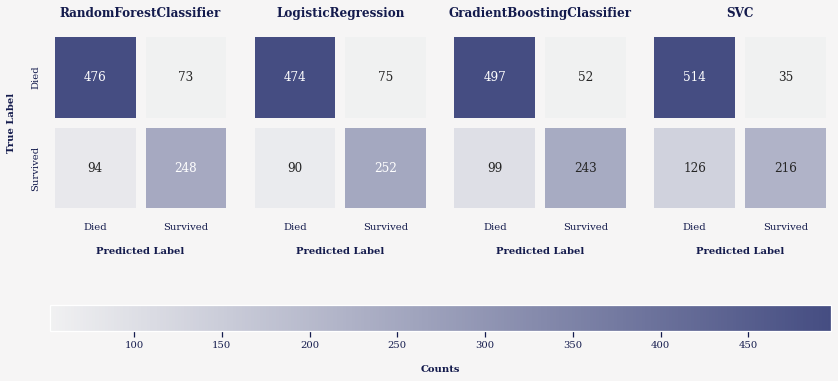

In [149]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(14, 6), facecolor=BACKGROUND_COLOR)
gs = GridSpec(nrows=2, ncols=4, figure=fig, height_ratios=(0.9, 0.1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, :])
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.1)

axes = (ax1, ax2, ax3, ax4)
titles = (
    rf_scores["Classifier"],
    lr_scores["Classifier"],
    gb_scores["Classifier"],
    sv_scores["Classifier"],
)
confusion_matrices = (
    rf_scores["ConfusionMatrix"],
    lr_scores["ConfusionMatrix"],
    gb_scores["ConfusionMatrix"],
    sv_scores["ConfusionMatrix"],
)

for ax, confusion_matrix, title in zip(axes, confusion_matrices, titles):
    plt.sca(ax)
    plt.title(title, fontsize=12)
    sns.heatmap(
        confusion_matrix,
        square=True,
        linewidths=10,
        linecolor=BACKGROUND_COLOR,
        annot=True,
        cmap=sns.light_palette("#454d82", as_cmap=True),
        fmt=".0f",
        annot_kws={"fontsize": 12},
        cbar=False,
    )
    plt.xlabel("Predicted Label")
    plt.gca().set_xticklabels(["Died", "Survived"])
    plt.gca().set_yticklabels(["Died", "Survived"])
    if not ax == ax1:
        plt.gca().set_yticklabels([])

plt.sca(ax1)
plt.ylabel("True Label")
plt.sca(ax2)

ax5.grid(False)
fig.colorbar(ax3.get_children()[0], cax=ax5, orientation="horizontal", label="Counts")

plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As in the previous note, we see here that both <code>GradientBoostingClassifier</code> and <code>SVC</code> handle well with the negative class. However, <code>SVC</code> doesn't cope with the positive one.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see ROC curves yet.</li>
</ul>

In [150]:
fig = go.Figure()

for scores, style, color in zip(
    (rf_scores, lr_scores, gb_scores, sv_scores),
    ("solid", "dash", "dot", "dashdot"),
    ("#0f173b", "#c73c1a", "#454d82", "yellowgreen"),
):
    fig.add_trace(
        go.Scatter(
            x=scores["FPR-TPR-Threshold"][0],
            y=scores["FPR-TPR-Threshold"][1],
            name=scores["Classifier"],
            line=dict(dash=style, color=color),
        )
    )

fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        name="Dummy Classifier",
        line=dict(dash="longdash", color="black"),
    )
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
        range=(0, 1),
        title="False Positive Rate (Fall-Out)",
    ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=(0, 1),
        title="True Positive Rate (Recall)",
    ),
    legend=dict(title="Classifier"),
    title="Top-4 Most Promising Classifiers - ROC",
    height=500,
    width=750,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>The ROC curve constitutes a compromise between recall and specificity when changing the cut-off threshold, determining how to classify the sample. The recall is drawn on the y-axis, whereas specificity is on the x-axis.</li>
    <li>The higher the AUC-ROC score, the more effective the classifier is. In this case, all classifiers have very similar AUC-ROC values.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>As you can see throughout the notebook, it seems that <code>GradiendBoostingClassifier</code> is the best. However, we should see one thing yet - learning curves.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Learning Curves</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>In this section I'll show the learning curves of the above models. I got through several submissions, and it turns out that even if  <code>GradiendBoostingClassifier</code> appears to be the best model (also with regularisation to prevent overfitting), it's also unstable. This means that slight changes in hyperparameters lead to completely different final accuracy within the test dataset.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>In general, learning curves are helpful tools which can be used to diagnose overfit and underfit of the model. Let's create them.</li>
</ul>

In [308]:
from sklearn.model_selection import learning_curve


# Let's define these models once more time.
lr = make_pipeline(preprocess, LogisticRegression(random_state=42))
sv = make_pipeline(preprocess, SVC(random_state=42, probability=True))

# I introduce a small regularisation to RF and GBC.
rf = make_pipeline(
    preprocess,
    RandomForestClassifier(
        random_state=42, min_samples_split=24, min_samples_leaf=16, max_depth=4
    ),
)

gb = make_pipeline(
    preprocess,
    GradientBoostingClassifier(
        random_state=42, min_samples_split=32, min_samples_leaf=24, max_depth=3
    ),
)

rf_curves, lr_curves, sv_curves, gb_curves = {}, {}, {}, {}

for model, curves in zip(
    (rf, lr, sv, gb), (rf_curves, lr_curves, sv_curves, gb_curves)
):
    train_sizes, train_scores, valid_scores, *_ = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.01, 1.0, 100),
        cv=skfold,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
    )
    curves["Train Size"] = train_sizes
    curves["Train Score"] = train_scores.mean(axis=1)
    curves["Valid Score"] = valid_scores.mean(axis=1)


In [309]:
learning_curves = pd.DataFrame(
    {
        "Train Size": lr_curves["Train Size"],
        "LR Train Score": lr_curves["Train Score"],
        "LR Valid Score": lr_curves["Valid Score"],
        "SV Train Score": sv_curves["Train Score"],
        "SV Valid Score": sv_curves["Valid Score"],
        "RF Train Score": rf_curves["Train Score"],
        "RF Valid Score": rf_curves["Valid Score"],
        "GB Train Score": gb_curves["Train Score"],
        "GB Valid Score": gb_curves["Valid Score"],
    }
)

learning_curves.head()


,Train Size,LR Train Score,LR Valid Score,SV Train Score,SV Valid Score,RF Train Score,RF Valid Score,GB Train Score,GB Valid Score
0,8,1.000000,0.768727,1.000000,0.746330,0.612500,0.545381,0.612500,0.568976
1,16,0.918750,0.770986,0.912500,0.757503,0.543750,0.545381,0.543750,0.568976
2,24,0.829167,0.718340,0.854167,0.695843,0.537500,0.499563,0.537500,0.499563
3,32,0.821875,0.783333,0.834375,0.768739,0.528125,0.474594,0.528125,0.545381
4,40,0.800000,0.791199,0.805000,0.773233,0.542500,0.616167,0.542500,0.616167


In [315]:
fig = px.line(
    data_frame=learning_curves,
    height=500,
    width=800,
    x="Train Size",
    y=learning_curves.columns.difference(["Train Size"]),
    range_y=(0.74, 0.92),
    labels={"variable": "Classifier", "value": "Mean Accuracy"},
    title="Top-4 Most Promising Models - Learning Curves within Stratified 10-Fold",
    color="variable",
    line_dash="variable",
    color_discrete_sequence=[
        "#0f173b",
        "#0f173b",
        "#c73c1a",
        "#c73c1a",
        "#454d82",
        "#454d82",
        "yellowgreen",
        "yellowgreen",
    ],
    line_dash_sequence=[
        "solid",
        "solid",
        "dash",
        "dash",
        "dot",
        "dot",
        "dashdot",
        "dashdot",
    ],
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>You can deactivate a curve by clicking on it in the legend.</li>
    <li><code>GradientBoostingClassifier</code> (GB) can explain training set very well, but its prediction rules are helpless regarding new samples. It manifests in the gap between the training score and the validation score.</li>
    <li><code>LogisticRegression</code> (LR) constitutes an example of underfitting. In the case of several samples, the model can learn them excellently. Thus it has > 95% of accuracy. Nevertheless, when introducing more samples, the general performance drops and reaches a plateau. Adding more training examples won't help.</li>
    <li>In the case of <code>RandomForestClassifier</code> (RF) or <code>SVC</code> (SV), gaps between training and validating scores gradually decrease and validation curves all the time slowly move upwards.</li>
    <li>I tried different <code>GradientBoostingClassifier</code> hyperparameters, and we always have the overfitting issue here.</li>
    <li>To sum up, we should prefer <code>RandomForestClassifier</code> or <code>SVC</code>.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li></li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Tuning Best Model & Submission</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>In this section we're looking for best hyperparameters of <code>SVC</code>.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>It's time to tune the best model.</li>
</ul>

In [359]:
def print_search_info(search_instance, space=20):
    name = search_instance.best_estimator_[-1].__class__.__name__
    print(CLR + "name:".ljust(space), f"{BLUE}{name}{RESET}")
    print(CLR + "best_score:".ljust(space), f"{BLUE}{search_instance.best_score_}{RESET}")
    for hyperparameter, value in search_instance.best_params_.items():
        print(CLR + f"{hyperparameter}:".ljust(space), f"{BLUE}{value}{RESET}")


In [356]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint, expon, reciprocal, uniform


svc_kbest = make_pipeline(
    preprocess,
    SelectKBest(mutual_info_classif, k=10),  # type: ignore
    SVC(random_state=42),
)

svc_kbest_space = {
    "selectkbest__k": randint(5, 12),
    "svc__C": reciprocal(1e-2, 1e2),
    "svc__kernel": ("poly", "rbf", "sigmoid"),
    "svc__gamma": ("auto", "scale"),
    "svc__degree": (2, 3),
}

svc_kbest_search = RandomizedSearchCV(
    estimator=svc_kbest,
    param_distributions=svc_kbest_space,
    cv=skfold,
    n_iter=100,
    n_jobs=-1,
    scoring="accuracy",
    random_state=42,
)

svc_kbest_search.fit(X, y)
print_search_info(svc_kbest_search)

name:                SVC
best_score:          0.8304744069912611
selectkbest__k:      10
svc__C:              1.2030178871154662
svc__degree:         3
svc__gamma:          scale
svc__kernel:         rbf


In [363]:
svc_forest = make_pipeline(
    preprocess,
    SelectFromModel(RandomForestClassifier(random_state=42), threshold=0.03),
    SVC(random_state=42),
)

svc_forest_space = {
    "selectfrommodel__threshold": uniform(0.02, 0.05),
    "svc__C": reciprocal(1e-2, 1e2),
    "svc__kernel": ("poly", "rbf", "sigmoid"),
    "svc__gamma": ("auto", "scale"),
    "svc__degree": (2, 3),
}

svc_forest_search = RandomizedSearchCV(
    estimator=svc_forest,
    param_distributions=svc_forest_space,
    cv=skfold,
    n_iter=100,
    n_jobs=-1,
    scoring="accuracy",
    random_state=42,
)

svc_forest_search.fit(X, y)
print_search_info(svc_forest_search, space=30)


name:                          SVC
best_score:                    0.8271285892634207
selectfrommodel__threshold:    0.04167603687903711
svc__C:                        9.466088751875803
svc__degree:                   3
svc__gamma:                    auto
svc__kernel:                   rbf


In [ ]:
# model_kbest = make_pipeline(
#     preprocess,
#     SelectKBest(mutual_info_classif, k=10),  # type: ignore
#     # SelectFromModel(RandomForestClassifier(random_state=42), threshold=0.02),
#     SVC(random_state=42, C=10, kernel='poly', degree=2),
# )

# score = cross_val_score(model_kbest, X, y, cv=skfold, scoring="accuracy")
# pd.Series(score).describe()


In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, expon, reciprocal, uniform


# gb_prefix = "gradientboostingclassifier__"
# gb_prefix_len = len(gb_prefix)

# gb_space = {
#     gb_prefix + "learning_rate": reciprocal(0.01, 1.0),
#     gb_prefix + "max_depth": randint(2, 4),
#     gb_prefix + "min_samples_split": randint(32, 64),
#     gb_prefix + "min_samples_leaf": randint(16, 32),
#     gb_prefix + "min_impurity_decrease": reciprocal(1e-3, 1e-1),
#     gb_prefix + "subsample": uniform(0.5, 0.25),
#     gb_prefix + "max_features": ("sqrt", "log2"),
# }

# gb_search = RandomizedSearchCV(
#     estimator=gb,
#     param_distributions=gb_space,
#     cv=skfold,
#     n_iter=100,
#     n_jobs=-1,
#     scoring="accuracy",
#     random_state=42,
# )

# gb_search.fit(X, y)
# print_search_info(gb_search, gb_prefix_len)


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>One of the most important hyperparameters to tune for tree-based boosted models are:</li>
        <ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
        <li><code>learning_rate</code> - Shrinks the contribution of each tree. A lower <code>learning_rate</code> value means you want to use more trees.</li>
        <li><code>n_estimators</code> - Boosting rounds. If different hyperparameters which prevent overfitting are set, the more boosting rounds won't break anything.</li>
        <li><code>max_depth</code> - Max depth of each tree.</li>
        <li><code>min_samples_split</code> - Minimum number of samples in the node to split it.</li>
        <li><code>min_samples_leaf</code> - Minimum number of samples in the tree leaf.</li>
        <li><code>subsample</code> - Fraction of predictors to use in each tree training process.</li>
    </ul>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's submit the final predictions.</li>
</ul>

In [238]:
lr.fit(X, y)

sumbission = pd.DataFrame(
    {
        "PassengerId": test.index,
        "Survived": lr.predict(test),
    }
).set_index("PassengerId")

sumbission.to_csv("submission.csv")
sumbission.head()


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>If you read this, thank you.</li>
</ul>